In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping
from nets.yolo4 import yolo_body
from nets.loss import yolo_loss
from utils.utils import get_random_data, get_random_data_with_Mosaic, rand, WarmUpCosineDecayScheduler, ModelCheckpoint
import os

#---------------------------------------------------#
#   获得类和先验框
#---------------------------------------------------#
def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)

#---------------------------------------------------#
#   训练数据生成器
#---------------------------------------------------#
def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes, mosaic=False):
    '''data generator for fit_generator'''
    n = len(annotation_lines)
    i = 0
    flag = True
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(annotation_lines)
            if mosaic:
                if flag and (i+4) < n:
                    image, box = get_random_data_with_Mosaic(annotation_lines[i:i+4], input_shape)
                    i = (i+1) % n
                else:
                    image, box = get_random_data(annotation_lines[i], input_shape)
                    i = (i+1) % n
                flag = bool(1-flag)
            else:
                image, box = get_random_data(annotation_lines[i], input_shape)
                i = (i+1) % n
            image_data.append(image)
            box_data.append(box)
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        yield [image_data, *y_true], np.zeros(batch_size)


#---------------------------------------------------#
#   读入xml文件，并输出y_true
#---------------------------------------------------#
def preprocess_true_boxes(true_boxes, input_shape, anchors, num_classes):
    assert (true_boxes[..., 4]<num_classes).all(), 'class id must be less than num_classes'
    # 一共有三个特征层数
    num_layers = len(anchors)//3
    # 先验框
    # 678为 142,110,  192,243,  459,401
    # 345为 36,75,  76,55,  72,146
    # 012为 12,16,  19,36,  40,28
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] if num_layers==3 else [[3,4,5], [1,2,3]]

    true_boxes = np.array(true_boxes, dtype='float32')
    input_shape = np.array(input_shape, dtype='int32') # 416,416
    # 读出xy轴，读出长宽
    # 中心点(m,n,2)
    boxes_xy = (true_boxes[..., 0:2] + true_boxes[..., 2:4]) // 2
    boxes_wh = true_boxes[..., 2:4] - true_boxes[..., 0:2]
    # 计算比例
    true_boxes[..., 0:2] = boxes_xy/input_shape[::-1]
    true_boxes[..., 2:4] = boxes_wh/input_shape[::-1]

    # m张图
    m = true_boxes.shape[0]
    # 得到网格的shape为13,13;26,26;52,52
    grid_shapes = [input_shape//{0:32, 1:16, 2:8}[l] for l in range(num_layers)]
    # y_true的格式为(m,13,13,3,85)(m,26,26,3,85)(m,52,52,3,85)
    y_true = [np.zeros((m,grid_shapes[l][0],grid_shapes[l][1],len(anchor_mask[l]),5+num_classes),
        dtype='float32') for l in range(num_layers)]
    # [1,9,2]
    anchors = np.expand_dims(anchors, 0)
    anchor_maxes = anchors / 2.
    anchor_mins = -anchor_maxes
    # 长宽要大于0才有效
    valid_mask = boxes_wh[..., 0]>0

    for b in range(m):
        # 对每一张图进行处理
        wh = boxes_wh[b, valid_mask[b]]
        if len(wh)==0: continue
        # [n,1,2]
        wh = np.expand_dims(wh, -2)
        box_maxes = wh / 2.
        box_mins = -box_maxes

        # 计算真实框和哪个先验框最契合
        intersect_mins = np.maximum(box_mins, anchor_mins)
        intersect_maxes = np.minimum(box_maxes, anchor_maxes)
        intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
        intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
        box_area = wh[..., 0] * wh[..., 1]
        anchor_area = anchors[..., 0] * anchors[..., 1]
        iou = intersect_area / (box_area + anchor_area - intersect_area)
        # 维度是(n) 感谢 消尽不死鸟 的提醒
        best_anchor = np.argmax(iou, axis=-1)

        for t, n in enumerate(best_anchor):
            for l in range(num_layers):
                if n in anchor_mask[l]:
                    # floor用于向下取整
                    i = np.floor(true_boxes[b,t,0]*grid_shapes[l][1]).astype('int32')
                    j = np.floor(true_boxes[b,t,1]*grid_shapes[l][0]).astype('int32')
                    # 找到真实框在特征层l中第b副图像对应的位置
                    k = anchor_mask[l].index(n)
                    c = true_boxes[b,t, 4].astype('int32')
                    y_true[l][b, j, i, k, 0:4] = true_boxes[b,t, 0:4]
                    y_true[l][b, j, i, k, 4] = 1
                    y_true[l][b, j, i, k, 5+c] = 1

    return y_true

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    

In [2]:
import os
import random 
 
xmlfilepath=r'./VOCdevkit/VOC2007/Annotations'
saveBasePath=r"./VOCdevkit/VOC2007/ImageSets/Main/"
 
trainval_percent=1
train_percent=1

temp_xml = os.listdir(xmlfilepath)
total_xml = []
for xml in temp_xml:
    if xml.endswith(".xml"):
        total_xml.append(xml)

num=len(total_xml)  
list=range(num)  
tv=int(num*trainval_percent)  
tr=int(tv*train_percent)  
trainval= random.sample(list,tv)  
train=random.sample(trainval,tr)  
 
print("train and val size",tv)
print("traub suze",tr)
ftrainval = open(os.path.join(saveBasePath,'trainval.txt'), 'w')  
ftest = open(os.path.join(saveBasePath,'test.txt'), 'w')  
ftrain = open(os.path.join(saveBasePath,'train.txt'), 'w')  
fval = open(os.path.join(saveBasePath,'val.txt'), 'w')  
 
for i in list:  
    name=total_xml[i][:-4]+'\n'  
    if i in trainval:  
        ftrainval.write(name)  
        if i in train:  
            ftrain.write(name)  
        else:  
            fval.write(name)  
    else:  
        ftest.write(name)  
        
ftrainval.close()  
ftrain.close()  
fval.close()  
ftest .close()

train and val size 800
traub suze 800


In [4]:
import xml.etree.ElementTree as ET
from os import getcwd

sets=[('2007', 'train'), ('2007', 'val'), ('2007', 'test')]

# classes = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
classes = ['Mango']

def convert_annotation(year, image_id, list_file):
    in_file = open('VOCdevkit/VOC%s/Annotations/%s.xml'%(year, image_id), encoding='utf-8')
    tree=ET.parse(in_file)
    root = tree.getroot()

    for obj in root.iter('object'):
        difficult = 0 
        if obj.find('difficult')!=None:
            difficult = obj.find('difficult').text
            
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
        list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

wd = getcwd()

for year, image_set in sets:
    image_ids = open('VOCdevkit/VOC%s/ImageSets/Main/%s.txt'%(year, image_set)).read().strip().split()
    list_file = open('%s_%s.txt'%(year, image_set), 'w', encoding="utf-8")
    for image_id in image_ids:
        list_file.write('%s/VOCdevkit/VOC%s/JPEGImages/%s.jpg'%(wd, year, image_id))
        convert_annotation(year, image_id, list_file)
        list_file.write('\n')
    list_file.close()


In [5]:
# 标签的位置
annotation_path = '2007_train.txt'
# 获取classes和anchor的位置
classes_path = 'model_data/my_classes.txt'    
anchors_path = 'model_data/yolo_anchors.txt'
#------------------------------------------------------#
#   权值文件请看README，百度网盘下载
#   训练自己的数据集时提示维度不匹配正常
#   预测的东西都不一样了自然维度不匹配
#------------------------------------------------------#
weights_path = 'model_data/yolo4_weight.h5'
# 获得classes和anchor
class_names = get_classes(classes_path)
anchors = get_anchors(anchors_path)
# 一共有多少类
num_classes = len(class_names)
num_anchors = len(anchors)
# 输入的shape大小
# 显存比较小可以使用416x416
# 现存比较大可以使用608x608
input_shape = (416,416)
mosaic = True
Cosine_scheduler = False
label_smoothing = 0

# 输入的图像为
image_input = Input(shape=(None, None, 3))
h, w = input_shape

# 创建yolo模型
print('Create YOLOv4 model with {} anchors and {} classes.'.format(num_anchors, num_classes))
model_body = yolo_body(image_input, num_anchors//3, num_classes)

# 载入预训练权重
print('Load weights {}.'.format(weights_path))
model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)

# y_true为13,13,3,85
# 26,26,3,85
# 52,52,3,85
y_true = [Input(shape=(h//{0:32, 1:16, 2:8}[l], w//{0:32, 1:16, 2:8}[l], \
    num_anchors//3, num_classes+5)) for l in range(3)]

# 输入为*model_body.input, *y_true
# 输出为model_loss
loss_input = [*model_body.output, *y_true]
model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
    arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.5, 'label_smoothing': label_smoothing})(loss_input)

model = Model([model_body.input, *y_true], model_loss)
model.summary()
# 训练后的模型保存的位置
log_dir = os.path.join("logs")
if not os.path.exists(log_dir):
    os.mkdir(log_dir)

# 训练参数设置
logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir+"/ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5", save_weights_only=True, save_best_only=False, period=1)
early_stopping = EarlyStopping(min_delta=0, patience=6, verbose=1)

# 0.1用于验证，0.9用于训练
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

Create YOLOv4 model with 9 anchors and 1 classes.
Load weights model_data/yolo4_weight.h5.
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 128         conv2d[0][0]                     
__________________________________________________________________________________________________
mish (Mish)                     (None, None, None, 3 0           batch_normalization[0][0]     

__________________________________________________________________________________________________
mish_23 (Mish)                  (None, None, None, 1 0           batch_normalization_23[0][0]     
__________________________________________________________________________________________________
add_4 (Add)                     (None, None, None, 1 0           add_3[0][0]                      
                                                                 mish_23[0][0]                    
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, None, None, 1 16384       add_4[0][0]                      
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, None, None, 1 512         conv2d_24[0][0]                  
__________________________________________________________________________________________________
mish_24 (M

__________________________________________________________________________________________________
batch_normalization_43 (BatchNo (None, None, None, 2 1024        conv2d_43[0][0]                  
__________________________________________________________________________________________________
mish_43 (Mish)                  (None, None, None, 2 0           batch_normalization_43[0][0]     
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, None, None, 2 589824      mish_43[0][0]                    
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, None, None, 2 1024        conv2d_44[0][0]                  
__________________________________________________________________________________________________
mish_44 (Mish)                  (None, None, None, 2 0           batch_normalization_44[0][0]     
__________

batch_normalization_64 (BatchNo (None, None, None, 5 2048        conv2d_64[0][0]                  
__________________________________________________________________________________________________
mish_64 (Mish)                  (None, None, None, 5 0           batch_normalization_64[0][0]     
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, None, None, 5 2359296     mish_64[0][0]                    
__________________________________________________________________________________________________
batch_normalization_65 (BatchNo (None, None, None, 5 2048        conv2d_65[0][0]                  
__________________________________________________________________________________________________
mish_65 (Mish)                  (None, None, None, 5 0           batch_normalization_65[0][0]     
__________________________________________________________________________________________________
add_20 (Ad

__________________________________________________________________________________________________
leaky_re_lu_8 (LeakyReLU)       (None, None, None, 2 0           batch_normalization_80[0][0]     
__________________________________________________________________________________________________
conv2d_81 (Conv2D)              (None, None, None, 5 1179648     leaky_re_lu_8[0][0]              
__________________________________________________________________________________________________
batch_normalization_81 (BatchNo (None, None, None, 5 2048        conv2d_81[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, None, None, 5 0           batch_normalization_81[0][0]     
__________________________________________________________________________________________________
conv2d_82 (Conv2D)              (None, None, None, 2 131072      leaky_re_lu_9[0][0]              
__________

In [6]:
#------------------------------------------------------#
#   主干特征提取网络特征通用，冻结训练可以加快训练速度
#   也可以在训练初期防止权值被破坏。
#   Init_Epoch为起始世代
#   Freeze_Epoch为冻结训练的世代
#   Epoch总训练世代
#   提示OOM或者显存不足请调小Batch_size
#------------------------------------------------------#
freeze_layers = 302
for i in range(freeze_layers): model_body.layers[i].trainable = False
print('Freeze the first {} layers of total {} layers.'.format(freeze_layers, len(model_body.layers)))

# 调整非主干模型first
if True:
    Init_epoch = 0
    Freeze_epoch = 50
    # batch_size大小，每次喂入多少数据
    batch_size = 1
    # 最大学习率
    learning_rate_base = 1e-3
    if Cosine_scheduler:
        # 预热期
        warmup_epoch = int((Freeze_epoch-Init_epoch)*0.2)
        # 总共的步长
        total_steps = int((Freeze_epoch-Init_epoch) * num_train / batch_size)
        # 预热步长
        warmup_steps = int(warmup_epoch * num_train / batch_size)
        # 学习率
        reduce_lr = WarmUpCosineDecayScheduler(learning_rate_base=learning_rate_base,
                                                    total_steps=total_steps,
                                                    warmup_learning_rate=1e-4,
                                                    warmup_steps=warmup_steps,
                                                    hold_base_rate_steps=num_train,
                                                    min_learn_rate=1e-6
                                                    )
        model.compile(optimizer=Adam(), loss={'yolo_loss': lambda y_true, y_pred: y_pred})
    else:
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
        model.compile(optimizer=Adam(learning_rate_base), loss={'yolo_loss': lambda y_true, y_pred: y_pred})

    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit(data_generator(lines[:num_train], batch_size, input_shape, anchors, num_classes, mosaic=mosaic),
             steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator(lines[num_train:], batch_size, input_shape, anchors, num_classes, mosaic=False),
            validation_steps=max(1, num_val//batch_size),
            epochs=Freeze_epoch,
            initial_epoch=Init_epoch,
            max_queue_size=1,
            callbacks=[logging, checkpoint, reduce_lr, early_stopping],
            )
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

for i in range(freeze_layers): model_body.layers[i].trainable = True

# 解冻后训练
if True:
    Freeze_epoch = 50
    Epoch = 100
    # batch_size大小，每次喂入多少数据
    batch_size = 1

    # 最大学习率
    learning_rate_base = 1e-4
    if Cosine_scheduler:
        # 预热期
        warmup_epoch = int((Epoch-Freeze_epoch)*0.2)
        # 总共的步长
        total_steps = int((Epoch-Freeze_epoch) * num_train / batch_size)
        # 预热步长
        warmup_steps = int(warmup_epoch * num_train / batch_size)
        # 学习率
        reduce_lr = WarmUpCosineDecayScheduler(learning_rate_base=learning_rate_base,
                                                    total_steps=total_steps,
                                                    warmup_learning_rate=1e-5,
                                                    warmup_steps=warmup_steps,
                                                    hold_base_rate_steps=num_train//2,
                                                    min_learn_rate=1e-6
                                                    )
        model.compile(optimizer=Adam(), loss={'yolo_loss': lambda y_true, y_pred: y_pred})
    else:
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
        model.compile(optimizer=Adam(learning_rate_base), loss={'yolo_loss': lambda y_true, y_pred: y_pred})

    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit_generator(data_generator(lines[:num_train], batch_size, input_shape, anchors, num_classes, mosaic=mosaic),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator(lines[num_train:], batch_size, input_shape, anchors, num_classes, mosaic=False),
            validation_steps=max(1, num_val//batch_size),
            epochs=Epoch,
            initial_epoch=Freeze_epoch,
            max_queue_size=1,
            callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'last1.h5')


Freeze the first 302 layers of total 370 layers.
Train on 720 samples, val on 80 samples, with batch size 1.
Epoch 1/50
  1/720 [..............................] - ETA: 0s - loss: 10536.2139WARNING:tensorflow:From C:\Users\10902306\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
720/720 [==============================] - 1297s 2s/step - loss: 246.8098 - val_loss: 63.3985
Epoch 2/50
720/720 [==============================] - 1267s 2s/step - loss: 61.3208 - val_loss: nan


C:\Users\10902306\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\callbacks.py:2347: RuntimeWarning: invalid value encountered in less
  self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)
C:\Users\10902306\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\callbacks.py:1664: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


Epoch 3/50
720/720 [==============================] - 1342s 2s/step - loss: 58.6280 - val_loss: 57.1397
Epoch 4/50
720/720 [==============================] - 1482s 2s/step - loss: 56.8690 - val_loss: nan
Epoch 5/50
365/720 [==============>...............] - ETA: 11:23 - loss: 55.6688

KeyboardInterrupt: 

## Predict

In [1]:
from yolo import YOLO
from PIL import Image
import time
import cv2
import tensorflow as tf
import os
import sys
import matplotlib.pyplot as plt
import gc
  
# 初始化YOLO
# 將欲使用的權重更名為'my_weight.h5'放在model_data資料夾中
# 進到yolo.py中, 將weight和class的路徑修改
yolo = YOLO()

model_data/ep052-loss1.778-val_loss1.232.h5 model, anchors, and 1 classes loaded.


Found 8 boxes for img
b'person 0.97' 136 783 406 900
b'person 0.95' 136 183 509 297
b'person 0.92' 148 397 395 486
b'person 0.85' 131 498 400 588
b'person 0.81' 163 288 506 402
b'person 0.72' 134 682 410 757
b'person 0.71' 133 609 401 692
b'person 0.70' 134 728 411 808


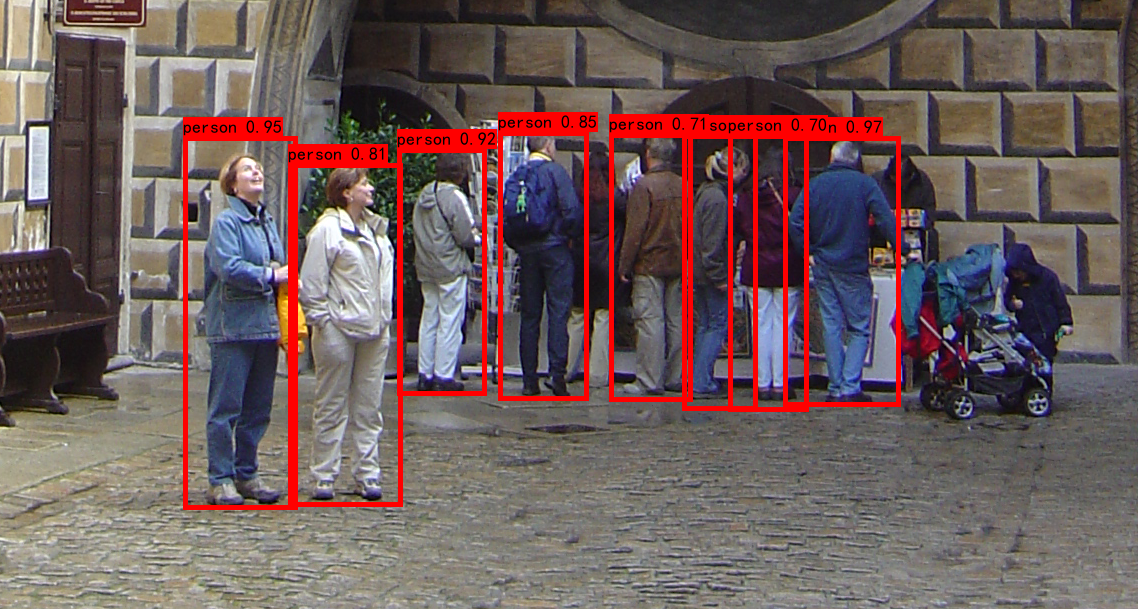

In [2]:
# Detect pictures
cwd = os.getcwd()
img_path = 'C:/Users/10902306/Desktop/Python/Yolov4_pedestrian/PedestrianData/INRIA/data/test/crop001607.png'
image_cv2 = cv2.imread(img_path, cv2.IMREAD_COLOR)
image_yolo = Image.fromarray(cv2.cvtColor(image_cv2,cv2.COLOR_BGR2RGB))  
r_image= yolo.detect_image(image_yolo)
r_image

In [ ]:
# 偵測影片
#-------------------------------------------------------------------------#
#   video_path用于指定视频的路径，当video_path=0时表示检测摄像头
#   video_save_path表示视频保存的路径，当video_save_path=""时表示不保存
#   video_fps用于保存的视频的fps
#   video_path、video_save_path和video_fps仅在mode='video'时有效
#   保存视频时需要ctrl+c退出才会完成完整的保存步骤，不可直接结束程序。
#-------------------------------------------------------------------------#
# video_path      = 0 # 攝像頭
video_path = 'C:/Users/10902306/Desktop/Python/Yolov4_pedestrian/PedestrianData/pedestrian.mp4'
video_save_path = 'C:/Users/10902306/Desktop/Python/Yolov4_pedestrian/PedestrianData/pedestrian_out.avi'
video_fps       = 25.0

capture=cv2.VideoCapture(video_path)
if video_save_path!="":
    fourcc = cv2.VideoWriter_fourcc(*'XVID') # MJPG:mp4
    size = (int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)), int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    out = cv2.VideoWriter(video_save_path, fourcc, video_fps, size)

fps = 0.0
while(True):
    t1 = time.time()
    # 读取某一帧
    ref, frame=capture.read()
    # 格式转变，BGRtoRGB
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    # 转变成Image
    frame = Image.fromarray(np.uint8(frame))
    # 进行检测
    frame = np.array(yolo.detect_image(frame))
    # RGBtoBGR满足opencv显示格式
    frame = cv2.cvtColor(frame,cv2.COLOR_RGB2BGR)

    fps  = ( fps + (1./(time.time()-t1)) ) / 2
    print("fps= %.2f"%(fps))
    frame = cv2.putText(frame, "fps= %.2f"%(fps), (0, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    cv2.imshow("video",frame)
    c= cv2.waitKey(1) & 0xff 
    if video_save_path!="":
        out.write(frame)

    if c==27:
        capture.release()
        break
capture.release()
out.release()
cv2.destroyAllWindows()

Found 3 boxes for img
b'person 0.85' 786 237 1080 367
b'person 0.69' 599 1597 855 1713
b'person 0.65' 384 863 623 996
fps= 0.60
Found 3 boxes for img
b'person 0.74' 797 230 1080 367
b'person 0.69' 602 1595 855 1713
b'person 0.61' 387 858 620 991
fps= 0.65
Found 3 boxes for img
b'person 0.74' 796 230 1080 367
b'person 0.69' 601 1595 855 1713
b'person 0.61' 387 858 620 991
fps= 0.60
Found 3 boxes for img
b'person 0.74' 796 230 1080 367
b'person 0.69' 601 1595 855 1713
b'person 0.62' 387 858 620 991
fps= 0.63
Found 4 boxes for img
b'person 0.83' 787 224 1080 352
b'person 0.74' 385 850 623 979
b'person 0.69' 602 1595 853 1713
b'person 0.35' 229 794 420 872
fps= 0.61
Found 6 boxes for img
b'person 0.84' 794 222 1080 342
b'person 0.79' 386 844 630 967
b'person 0.67' 604 1595 856 1714
b'person 0.55' 986 624 1079 820
b'person 0.39' 227 277 486 375
b'person 0.32' 226 798 422 878
fps= 0.72
Found 4 boxes for img
b'person 0.82' 800 220 1080 341
b'person 0.81' 388 841 635 963
b'person 0.67' 607 159

Found 3 boxes for img
b'person 0.88' 542 608 813 746
b'person 0.64' 728 864 998 985
b'person 0.36' 765 1640 1047 1738
fps= 0.74
Found 4 boxes for img
b'person 0.86' 548 604 822 741
b'person 0.71' 724 868 993 986
b'person 0.49' 781 1636 1058 1738
b'person 0.30' 57 1641 210 1718
fps= 0.72
Found 3 boxes for img
b'person 0.78' 551 599 824 740
b'person 0.65' 721 875 990 991
b'person 0.55' 784 1634 1059 1736
fps= 0.70
Found 3 boxes for img
b'person 0.78' 551 599 824 740
b'person 0.65' 721 875 991 991
b'person 0.55' 784 1634 1058 1736
fps= 0.73
Found 3 boxes for img
b'person 0.83' 549 589 831 727
b'person 0.66' 720 878 982 997
b'person 0.61' 788 1633 1057 1735
fps= 0.68
Found 3 boxes for img
b'person 0.85' 552 590 838 721
b'person 0.70' 788 1632 1059 1735
b'person 0.69' 718 883 981 1001
fps= 0.68
Found 3 boxes for img
b'person 0.85' 554 587 841 722
b'person 0.76' 716 886 978 1005
b'person 0.66' 791 1634 1059 1734
fps= 0.67
Found 3 boxes for img
b'person 0.82' 559 584 840 718
b'person 0.71' 71

Found 3 boxes for img
b'person 0.94' 767 326 1074 483
b'person 0.86' 503 1685 772 1803
b'person 0.76' 560 1038 793 1149
fps= 0.87
Found 3 boxes for img
b'person 0.94' 767 325 1074 483
b'person 0.86' 503 1685 772 1802
b'person 0.76' 560 1038 793 1149
fps= 0.87
Found 3 boxes for img
b'person 0.94' 769 313 1073 473
b'person 0.85' 509 1683 778 1797
b'person 0.72' 558 1042 791 1153
fps= 0.86
Found 3 boxes for img
b'person 0.92' 772 307 1071 466
b'person 0.81' 514 1680 780 1793
b'person 0.64' 557 1041 786 1157
fps= 0.85
Found 3 boxes for img
b'person 0.93' 775 299 1074 461
b'person 0.83' 520 1676 785 1791
b'person 0.56' 557 1041 781 1160
fps= 0.87
Found 3 boxes for img
b'person 0.86' 522 1671 787 1790
b'person 0.85' 778 291 1074 457
b'person 0.51' 553 1043 782 1161
fps= 0.86
Found 3 boxes for img
b'person 0.84' 523 1669 786 1786
b'person 0.81' 778 287 1079 438
b'person 0.53' 542 1058 776 1165
fps= 0.87
Found 3 boxes for img
b'person 0.84' 523 1669 786 1786
b'person 0.80' 777 288 1078 438
b'p

Found 3 boxes for img
b'person 0.57' 429 1151 641 1261
b'person 0.48' 667 1649 975 1769
b'person 0.46' 440 163 669 269
fps= 0.80
Found 3 boxes for img
b'person 0.62' 428 1156 639 1264
b'person 0.44' 436 168 668 282
b'person 0.36' 678 1644 1002 1770
fps= 0.83
Found 3 boxes for img
b'person 0.64' 432 171 665 282
b'person 0.64' 428 1159 638 1266
b'person 0.36' 682 1647 1009 1763
fps= 0.82
Found 3 boxes for img
b'person 0.63' 429 1163 636 1270
b'person 0.63' 430 177 662 287
b'person 0.48' 686 1646 1013 1766
fps= 0.85
Found 3 boxes for img
b'person 0.65' 428 1165 635 1271
b'person 0.56' 431 186 658 298
b'person 0.42' 692 1648 1012 1762
fps= 0.87
Found 3 boxes for img
b'person 0.66' 425 1165 636 1274
b'person 0.58' 431 193 659 307
b'person 0.32' 695 1650 1010 1760
fps= 0.84
Found 3 boxes for img
b'person 0.66' 426 1165 636 1274
b'person 0.58' 431 193 659 307
b'person 0.32' 695 1650 1010 1759
fps= 0.82
Found 3 boxes for img
b'person 0.65' 418 1170 630 1274
b'person 0.53' 432 196 658 311
b'per

Found 3 boxes for img
b'person 0.85' 791 1460 1080 1583
b'person 0.38' 311 382 537 483
b'person 0.33' 319 1274 495 1365
fps= 0.70
Found 4 boxes for img
b'person 0.87' 790 1463 1080 1585
b'person 0.35' 1002 1502 1080 1707
b'person 0.30' 320 1276 495 1365
b'person 0.30' 312 382 537 485
fps= 0.67
Found 2 boxes for img
b'person 0.87' 787 1466 1080 1589
b'person 0.32' 1005 1497 1080 1711
fps= 0.69
Found 1 boxes for img
b'person 0.88' 785 1470 1080 1593
fps= 0.74
Found 1 boxes for img
b'person 0.88' 782 1470 1080 1596
fps= 0.75
Found 1 boxes for img
b'person 0.87' 777 1472 1080 1598
fps= 0.81
Found 1 boxes for img
b'person 0.87' 777 1472 1080 1598
fps= 0.80
Found 1 boxes for img
b'person 0.87' 772 1475 1077 1601
fps= 0.74
Found 2 boxes for img
b'person 0.84' 769 1478 1071 1603
b'person 0.32' 312 407 497 498
fps= 0.75
Found 2 boxes for img
b'person 0.80' 759 1486 1056 1600
b'person 0.33' 326 130 534 235
fps= 0.78
Found 3 boxes for img
b'person 0.86' 760 1489 1044 1601
b'person 0.42' 298 406 5